# PTB-XL Multi-Label Classification Baseline

**Objective:** Build a baseline multi-label classification pipeline to predict diagnostic superclasses from 12-lead ECG signals.

---

## Target Superclasses

| Code | Description | Type |
|------|-------------|------|
| **NORM** | Normal ECG | Healthy |
| **MI** | Myocardial Infarction | Diagnostic |
| **STTC** | ST/T Changes | Diagnostic |
| **CD** | Conduction Disturbance | Diagnostic |
| **HYP** | Hypertrophy | Diagnostic |

---

## Pipeline Overview

1. **Target Construction** — Parse SCP codes, create 5D binary labels
2. **Signal Loading** — Load 100Hz ECG, preprocess, extract features
3. **Cross-Validation** — Stratified 5-Fold CV
4. **Model Training** — Logistic Regression, Random Forest, SVM
5. **Evaluation** — Macro F1, Micro F1, AUROC, Precision, Recall
6. **Analysis** — Model comparison, feature importance

---

## Multi-Label vs Multi-Class

This is a **multi-label** problem:
- Each ECG can have **multiple diagnoses** (e.g., MI + STTC)
- We predict 5 independent binary outputs
- Use **One-vs-Rest** strategy for traditional classifiers

## 1. Imports & Configuration

In [ ]:
# ============================================================
# IMPORTS
# ============================================================

import os
import ast
import warnings
from pathlib import Path
from collections import Counter
from time import time

import numpy as np
import pandas as pd
import wfdb

from scipy import signal
from scipy.stats import skew, kurtosis

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score,
    classification_report, multilabel_confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Reproducibility
SEED = 42
np.random.seed(SEED)

print('All imports successful!')

All imports successful!


In [2]:
# ============================================================
# CONFIGURATION
# ============================================================

# Paths
DATA_PATH = Path('/Volumes/Crucial X6/medical_ai/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1')
OUTPUT_PATH = Path('/Volumes/Crucial X6/medical_ai/ptb-xl/outputs_baseline')
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Target superclasses (order matters for label vector)
SUPERCLASSES = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
N_CLASSES = len(SUPERCLASSES)

# ECG parameters
SAMPLING_RATE = 100  # Hz (using records100/)
N_LEADS = 12
LEAD_NAMES = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Cross-validation
N_FOLDS = 5

# Verify paths
assert DATA_PATH.exists(), f"Data path not found: {DATA_PATH}"
print(f'Data path: {DATA_PATH}')
print(f'Output path: {OUTPUT_PATH}')
print(f'Superclasses: {SUPERCLASSES}')
print(f'Sampling rate: {SAMPLING_RATE} Hz')

Data path: /Volumes/Crucial X6/medical_ai/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1
Output path: /Volumes/Crucial X6/medical_ai/ptb-xl/outputs_baseline
Superclasses: ['NORM', 'MI', 'STTC', 'CD', 'HYP']
Sampling rate: 100 Hz


## 2. Target Construction

### Steps:
1. Load `ptbxl_database.csv` with ECG metadata
2. Parse `scp_codes` column (dictionary format)
3. Load `scp_statements.csv` for SCP -> Superclass mapping
4. Create 5D binary target vector per ECG: `[NORM, MI, STTC, CD, HYP]`

In [3]:
# ============================================================
# LOAD METADATA
# ============================================================

# Load main database
df = pd.read_csv(DATA_PATH / 'ptbxl_database.csv')
print(f'Loaded {len(df):,} ECG records')
print(f'Columns: {list(df.columns[:10])}...')

# Parse scp_codes from string to dict
def parse_scp_codes(scp_str):
    try:
        return ast.literal_eval(scp_str)
    except:
        return {}

df['scp_codes_dict'] = df['scp_codes'].apply(parse_scp_codes)

# Show example
print('\nExample scp_codes:')
for i in [0, 7, 10]:
    print(f'  ECG {df.iloc[i]["ecg_id"]}: {df.iloc[i]["scp_codes_dict"]}')

Loaded 21,837 ECG records
Columns: ['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site', 'device', 'recording_date']...

Example scp_codes:
  ECG 1: {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
  ECG 8: {'IMI': 35.0, 'ABQRS': 0.0, 'SR': 0.0}
  ECG 11: {'NORM': 80.0, 'SARRH': 0.0}


In [4]:
# ============================================================
# LOAD SCP STATEMENTS (CODE -> SUPERCLASS MAPPING)
# ============================================================

# Load SCP statements
scp_df = pd.read_csv(DATA_PATH / 'scp_statements.csv', index_col=0)
print(f'Loaded {len(scp_df)} SCP statements')

# Filter to diagnostic codes only
scp_diagnostic = scp_df[scp_df['diagnostic'] == 1.0].copy()
print(f'Diagnostic codes: {len(scp_diagnostic)}')

# Create mapping: SCP code -> diagnostic superclass
scp_to_superclass = scp_diagnostic['diagnostic_class'].to_dict()

print('\nSCP to Superclass mapping (sample):')
for code, superclass in list(scp_to_superclass.items())[:10]:
    print(f'  {code:8s} -> {superclass}')

Loaded 71 SCP statements
Diagnostic codes: 44

SCP to Superclass mapping (sample):
  NDT      -> STTC
  NST_     -> STTC
  DIG      -> STTC
  LNGQT    -> STTC
  NORM     -> NORM
  IMI      -> MI
  ASMI     -> MI
  LVH      -> HYP
  LAFB     -> CD
  ISC_     -> STTC


In [5]:
# ============================================================
# CREATE MULTI-LABEL TARGETS
# ============================================================

def get_superclasses(scp_codes_dict, scp_to_superclass, superclasses):
    active = set()
    for scp_code, likelihood in scp_codes_dict.items():
        if likelihood > 0 and scp_code in scp_to_superclass:
            superclass = scp_to_superclass[scp_code]
            if superclass in superclasses:
                active.add(superclass)
    return list(active)

# Apply to all ECGs
df['superclasses'] = df['scp_codes_dict'].apply(
    lambda x: get_superclasses(x, scp_to_superclass, SUPERCLASSES)
)

# Filter to ECGs with at least one diagnostic superclass
df_filtered = df[df['superclasses'].apply(len) > 0].copy()
print(f'ECGs with diagnostic labels: {len(df_filtered):,} / {len(df):,}')

# Create binary label matrix
mlb = MultiLabelBinarizer(classes=SUPERCLASSES)
y = mlb.fit_transform(df_filtered['superclasses'])

print(f'\nLabel matrix shape: {y.shape}')
print(f'Classes: {mlb.classes_}')

ECGs with diagnostic labels: 21,417 / 21,837

Label matrix shape: (21417, 5)
Classes: ['NORM' 'MI' 'STTC' 'CD' 'HYP']


SUPERCLASS DISTRIBUTION

Total ECGs: 21,417

Superclass    Count Percentage
-----------------------------------
NORM          9,528     44.49%
MI            5,486     25.62%
STTC          5,123     23.92%
CD            4,907     22.91%
HYP           2,655     12.40%

Labels per ECG: min=1, max=4, mean=1.29


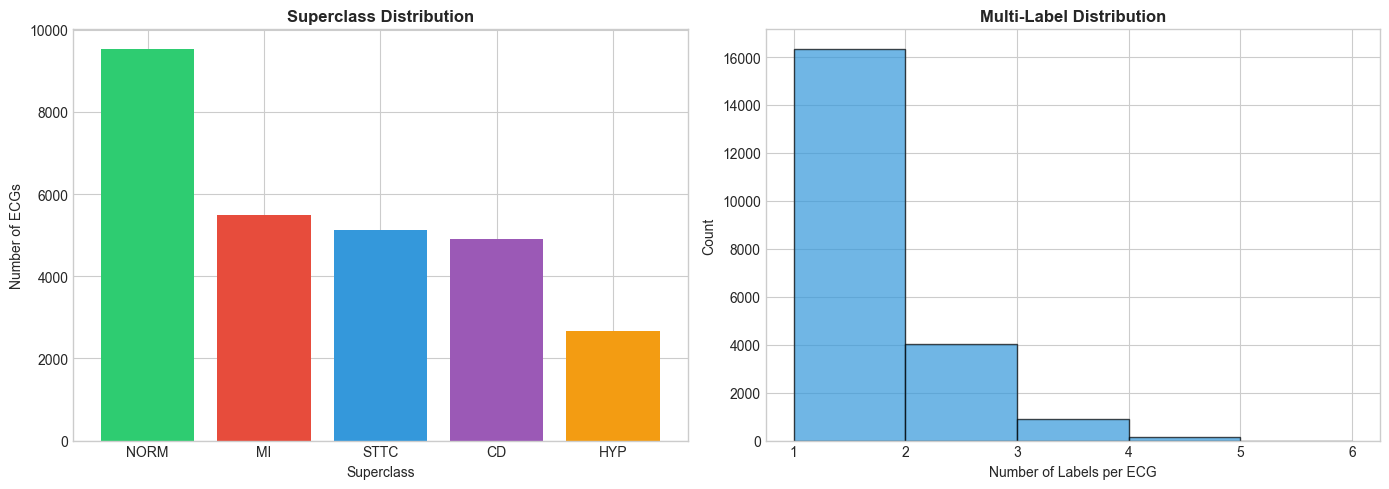

In [6]:
# ============================================================
# CLASS DISTRIBUTION
# ============================================================

print('=' * 60)
print('SUPERCLASS DISTRIBUTION')
print('=' * 60)

class_counts = y.sum(axis=0)
total = len(y)

print(f'\nTotal ECGs: {total:,}\n')
print(f'{"Superclass":<10} {"Count":>8} {"Percentage":>10}')
print('-' * 35)

for i, cls in enumerate(SUPERCLASSES):
    count = class_counts[i]
    pct = 100 * count / total
    print(f'{cls:<10} {count:>8,} {pct:>9.2f}%')

# Multi-label statistics
n_labels_per_ecg = y.sum(axis=1)
print(f'\nLabels per ECG: min={n_labels_per_ecg.min()}, max={n_labels_per_ecg.max()}, mean={n_labels_per_ecg.mean():.2f}')

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6', '#f39c12']
bars = axes[0].bar(SUPERCLASSES, class_counts, color=colors)
axes[0].set_xlabel('Superclass')
axes[0].set_ylabel('Number of ECGs')
axes[0].set_title('Superclass Distribution', fontweight='bold')

axes[1].hist(n_labels_per_ecg, bins=range(1, 7), edgecolor='black', alpha=0.7, color='#3498db')
axes[1].set_xlabel('Number of Labels per ECG')
axes[1].set_ylabel('Count')
axes[1].set_title('Multi-Label Distribution', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'class_distribution.png', dpi=150)
plt.show()

## 3. Signal Loading & Feature Extraction

### Preprocessing:
- Load 100Hz ECG signals using WFDB
- Z-score normalization per lead
- Optional bandpass filter (0.5-40 Hz)

### Features per lead:
- Mean, Standard Deviation
- Signal Energy
- Skewness, Kurtosis
- Estimated Heart Rate (R-peak detection)
- Approximate QRS Duration

In [7]:
# ============================================================
# SIGNAL LOADING FUNCTIONS
# ============================================================

def load_ecg_signal(filename, data_path):
    filepath = data_path / filename
    record = wfdb.rdrecord(str(filepath))
    return record.p_signal

def bandpass_filter(sig, lowcut=0.5, highcut=40, fs=100, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, sig, axis=0)

def detect_r_peaks(lead_signal, fs=100):
    nyq = 0.5 * fs
    b, a = signal.butter(2, [5/nyq, 15/nyq], btype='band')
    filtered = signal.filtfilt(b, a, lead_signal)
    squared = filtered ** 2
    window = int(0.12 * fs)
    ma = np.convolve(squared, np.ones(window)/window, mode='same')
    threshold = 0.5 * np.max(ma)
    min_distance = int(0.3 * fs)
    peaks, _ = signal.find_peaks(ma, height=threshold, distance=min_distance)
    return peaks

print('Signal loading functions defined.')

Signal loading functions defined.


In [8]:
# ============================================================
# FEATURE EXTRACTION FUNCTIONS
# ============================================================

def extract_lead_features(lead_signal, fs=100):
    features = {}
    
    features['mean'] = np.mean(lead_signal)
    features['std'] = np.std(lead_signal)
    features['min'] = np.min(lead_signal)
    features['max'] = np.max(lead_signal)
    features['ptp'] = np.ptp(lead_signal)
    features['median'] = np.median(lead_signal)
    features['skewness'] = skew(lead_signal)
    features['kurtosis'] = kurtosis(lead_signal)
    features['energy'] = np.sum(lead_signal ** 2)
    features['rms'] = np.sqrt(np.mean(lead_signal ** 2))
    
    try:
        r_peaks = detect_r_peaks(lead_signal, fs)
        if len(r_peaks) > 1:
            rr_intervals = np.diff(r_peaks) / fs
            features['heart_rate'] = 60 / np.mean(rr_intervals)
            features['hr_std'] = 60 / np.std(rr_intervals) if np.std(rr_intervals) > 0 else 0
            qrs_widths = []
            for peak in r_peaks[:min(5, len(r_peaks))]:
                start = max(0, peak - int(0.1*fs))
                end = min(len(lead_signal), peak + int(0.1*fs))
                segment = lead_signal[start:end]
                half_max = 0.5 * np.max(np.abs(segment))
                above_half = np.abs(segment) > half_max
                qrs_widths.append(np.sum(above_half) / fs * 1000)
            features['qrs_duration'] = np.mean(qrs_widths) if qrs_widths else 100
        else:
            features['heart_rate'] = 75
            features['hr_std'] = 0
            features['qrs_duration'] = 100
    except:
        features['heart_rate'] = 75
        features['hr_std'] = 0
        features['qrs_duration'] = 100
    
    fft = np.abs(np.fft.rfft(lead_signal))
    features['fft_mean'] = np.mean(fft)
    features['fft_max'] = np.max(fft)
    features['fft_std'] = np.std(fft)
    
    return features

def extract_ecg_features(ecg_signal, fs=100, lead_names=LEAD_NAMES):
    all_features = {}
    for i, lead_name in enumerate(lead_names):
        lead_signal = ecg_signal[:, i]
        lead_signal = (lead_signal - np.mean(lead_signal)) / (np.std(lead_signal) + 1e-8)
        lead_features = extract_lead_features(lead_signal, fs)
        for key, value in lead_features.items():
            all_features[f'{lead_name}_{key}'] = value
    all_features['global_energy'] = np.sum(ecg_signal ** 2)
    all_features['global_std'] = np.std(ecg_signal)
    return all_features

print('Feature extraction functions defined.')
print(f'Features per lead: {len(extract_lead_features(np.random.randn(1000)))}')

Feature extraction functions defined.
Features per lead: 16


In [9]:
# ============================================================
# EXTRACT FEATURES FOR ALL ECGs
# ============================================================

SAMPLE_SIZE = None  # Set to integer for faster testing

if SAMPLE_SIZE:
    df_sample = df_filtered.sample(n=SAMPLE_SIZE, random_state=SEED)
    indices_map = {old: new for new, old in enumerate(df_sample.index)}
    y_sample = y[[indices_map[i] for i in sorted(indices_map.keys())]]
else:
    df_sample = df_filtered.reset_index(drop=True)
    y_sample = y

print(f'Processing {len(df_sample):,} ECGs...')
print('=' * 60)

all_features = []
valid_indices = []
failed_count = 0

for idx, row in df_sample.iterrows():
    if len(all_features) % 2000 == 0:
        print(f'  Progress: {len(all_features):,} / {len(df_sample):,}')
    
    try:
        ecg = load_ecg_signal(row['filename_lr'], DATA_PATH)
        ecg = bandpass_filter(ecg, lowcut=0.5, highcut=40, fs=SAMPLING_RATE)
        features = extract_ecg_features(ecg, fs=SAMPLING_RATE)
        all_features.append(features)
        valid_indices.append(idx)
    except Exception as e:
        failed_count += 1

print(f'\nExtracted features for {len(all_features):,} ECGs')
print(f'Failed: {failed_count}')

X = pd.DataFrame(all_features).values
y_final = y_sample[valid_indices] if SAMPLE_SIZE else y_sample[:len(valid_indices)]

print(f'Feature matrix shape: {X.shape}')
print(f'Label matrix shape: {y_final.shape}')

Processing 21,417 ECGs...
  Progress: 0 / 21,417
  Progress: 2,000 / 21,417
  Progress: 4,000 / 21,417
  Progress: 6,000 / 21,417
  Progress: 8,000 / 21,417
  Progress: 10,000 / 21,417
  Progress: 12,000 / 21,417
  Progress: 14,000 / 21,417
  Progress: 16,000 / 21,417
  Progress: 18,000 / 21,417
  Progress: 20,000 / 21,417

Extracted features for 21,417 ECGs
Failed: 0
Feature matrix shape: (21417, 194)
Label matrix shape: (21417, 5)


In [10]:
# ============================================================
# HANDLE MISSING VALUES
# ============================================================

print('Checking for invalid values...')
nan_count = np.isnan(X).sum()
inf_count = np.isinf(X).sum()
print(f'  NaN: {nan_count}, Inf: {inf_count}')

if nan_count > 0 or inf_count > 0:
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    print('  Replaced invalid values')

feature_names = list(pd.DataFrame(all_features).columns)
print(f'Total features: {len(feature_names)}')

Checking for invalid values...
  NaN: 2, Inf: 0
  Replaced invalid values
Total features: 194


## 4. Cross-Validation Strategy

Stratified K-Fold on **number of active labels** per sample for balanced folds.

In [11]:
# ============================================================
# STRATIFIED K-FOLD SETUP
# ============================================================

n_labels = y_final.sum(axis=1).astype(int)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

print(f'{N_FOLDS}-FOLD CROSS-VALIDATION SETUP')
print('=' * 60)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, n_labels)):
    print(f'Fold {fold+1}: Train={len(train_idx):,}, Val={len(val_idx):,}')

5-FOLD CROSS-VALIDATION SETUP
Fold 1: Train=17,133, Val=4,284
Fold 2: Train=17,133, Val=4,284
Fold 3: Train=17,134, Val=4,283
Fold 4: Train=17,134, Val=4,283
Fold 5: Train=17,134, Val=4,283


## 5. Model Training (One-vs-Rest)

Models: Logistic Regression, Random Forest, SVM

In [14]:
# ============================================================
# MODEL DEFINITIONS
# ============================================================

def get_models(seed=42):
    return {
        'Logistic Regression': OneVsRestClassifier(
            LogisticRegression(max_iter=1000, class_weight='balanced', random_state=seed, n_jobs=-1)
        ),
        'Random Forest': OneVsRestClassifier(
            RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced', random_state=seed, n_jobs=-1)
        ),
        'SVM': OneVsRestClassifier(
            SVC(kernel='rbf', C=1.0, class_weight='balanced', probability=True, random_state=seed)
        )
    }

print('Models:', list(get_models().keys()))

Models: ['Logistic Regression', 'Random Forest', 'SVM']


In [ ]:
# ============================================================
# CROSS-VALIDATION TRAINING
# ============================================================

def evaluate_multilabel(y_true, y_pred, y_proba=None):
    metrics = {
        'macro_f1': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'micro_f1': f1_score(y_true, y_pred, average='micro', zero_division=0),
        'weighted_f1': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }
    for i, cls in enumerate(SUPERCLASSES):
        metrics[f'precision_{cls}'] = precision_score(y_true[:, i], y_pred[:, i], zero_division=0)
        metrics[f'recall_{cls}'] = recall_score(y_true[:, i], y_pred[:, i], zero_division=0)
        metrics[f'f1_{cls}'] = f1_score(y_true[:, i], y_pred[:, i], zero_division=0)
        if y_proba is not None:
            try:
                metrics[f'auroc_{cls}'] = roc_auc_score(y_true[:, i], y_proba[:, i])
            except:
                metrics[f'auroc_{cls}'] = np.nan
    return metrics

cv_results = {name: {'folds': []} for name in get_models().keys()}
scaler = StandardScaler()

print('=' * 70)
print(f'{N_FOLDS}-FOLD CROSS-VALIDATION')
print('=' * 70)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, n_labels)):
    print(f'\n--- FOLD {fold+1}/{N_FOLDS} ---')
    
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_final[train_idx], y_final[val_idx]
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    for name, model in get_models(SEED).items():
        t0 = time()
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        
        try:
            y_proba = model.predict_proba(X_val_scaled)
            if len(y_proba) == N_CLASSES:
                y_proba = np.column_stack([p[:, 1] for p in y_proba])
        except:
            y_proba = None
        
        metrics = evaluate_multilabel(y_val, y_pred, y_proba)
        metrics['train_time'] = time() - t0
        cv_results[name]['folds'].append(metrics)
        
        print(f'  {name:20s}: Macro F1={metrics["macro_f1"]:.4f}')

print('\nCross-validation complete!')

5-FOLD CROSS-VALIDATION

--- FOLD 1/5 ---


  Logistic Regression : Macro F1=0.6600
  Random Forest       : Macro F1=0.6652
  SVM                 : Macro F1=0.6971

--- FOLD 2/5 ---
  Logistic Regression : Macro F1=0.6558
  Random Forest       : Macro F1=0.6718
  SVM                 : Macro F1=0.6913

--- FOLD 3/5 ---
  Logistic Regression : Macro F1=0.6610
  Random Forest       : Macro F1=0.6621
  SVM                 : Macro F1=0.6952

--- FOLD 4/5 ---
  Logistic Regression : Macro F1=0.6550
  Random Forest       : Macro F1=0.6711
  SVM                 : Macro F1=0.6940

--- FOLD 5/5 ---
  Logistic Regression : Macro F1=0.6646
  Random Forest       : Macro F1=0.6638


## 6. Results Analysis

In [ ]:
# ============================================================
# AGGREGATE RESULTS
# ============================================================

print('\n' + '=' * 90)
print('CROSS-VALIDATION RESULTS (Mean +/- Std)')
print('=' * 90)

results_summary = []

for name, results in cv_results.items():
    folds = results['folds']
    row = {'Model': name}
    
    for metric in ['macro_f1', 'micro_f1', 'weighted_f1']:
        values = [f[metric] for f in folds]
        row[metric.replace('_', ' ').title()] = f"{np.mean(values):.4f} +/- {np.std(values):.4f}"
        row[f'{metric}_mean'] = np.mean(values)
    
    for cls in SUPERCLASSES:
        values = [f.get(f'auroc_{cls}', np.nan) for f in folds]
        row[f'AUROC {cls}'] = f"{np.nanmean(values):.4f}"
    
    results_summary.append(row)

df_results = pd.DataFrame(results_summary)
print(df_results[['Model', 'Macro F1', 'Micro F1', 'Weighted F1']].to_string(index=False))

best_model = max(results_summary, key=lambda x: x['macro_f1_mean'])
print(f'\nBEST MODEL: {best_model["Model"]} (Macro F1 = {best_model["macro_f1_mean"]:.4f})')

In [ ]:
# ============================================================
# PER-CLASS METRICS
# ============================================================

print('\nPER-CLASS AUROC')
print('=' * 60)
auroc_cols = ['Model'] + [f'AUROC {cls}' for cls in SUPERCLASSES]
print(df_results[auroc_cols].to_string(index=False))

# Worst class
worst_class_scores = {}
for cls in SUPERCLASSES:
    scores = [float(row[f'AUROC {cls}']) for row in results_summary]
    worst_class_scores[cls] = np.mean(scores)
worst_class = min(worst_class_scores, key=worst_class_scores.get)
print(f'\nWORST CLASS: {worst_class} (avg AUROC = {worst_class_scores[worst_class]:.4f})')

# Per-class for best model
best_folds = cv_results[best_model['Model']]['folds']
per_class_metrics = []
for cls in SUPERCLASSES:
    per_class_metrics.append({
        'Class': cls,
        'Precision': f"{np.mean([f[f'precision_{cls}'] for f in best_folds]):.4f}",
        'Recall': f"{np.mean([f[f'recall_{cls}'] for f in best_folds]):.4f}",
        'F1': f"{np.mean([f[f'f1_{cls}'] for f in best_folds]):.4f}",
        'AUROC': f"{np.nanmean([f.get(f'auroc_{cls}', np.nan) for f in best_folds]):.4f}"
    })
df_per_class = pd.DataFrame(per_class_metrics)
print(f'\nPER-CLASS METRICS ({best_model["Model"]})')
print(df_per_class.to_string(index=False))

In [ ]:
# ============================================================
# VISUALIZATION
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Model comparison
model_names = [r['Model'] for r in results_summary]
macro_f1_means = [r['macro_f1_mean'] for r in results_summary]
colors = ['#2ecc71' if m == best_model['Model'] else '#3498db' for m in model_names]
bars = axes[0].barh(model_names, macro_f1_means, color=colors)
axes[0].set_xlabel('Macro F1 Score')
axes[0].set_title('Model Comparison', fontweight='bold')

# Per-class AUROC
aurocs = [float(r['AUROC']) for r in per_class_metrics]
class_colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6', '#f39c12']
axes[1].bar(SUPERCLASSES, aurocs, color=class_colors)
axes[1].set_ylabel('AUROC')
axes[1].set_title(f'Per-Class AUROC ({best_model["Model"]})', fontweight='bold')
axes[1].set_ylim([0, 1])

# Precision vs Recall
precs = [float(r['Precision']) for r in per_class_metrics]
recs = [float(r['Recall']) for r in per_class_metrics]
axes[2].scatter(recs, precs, c=class_colors, s=200, edgecolors='black')
for i, cls in enumerate(SUPERCLASSES):
    axes[2].annotate(cls, (recs[i], precs[i]), xytext=(5, 5), textcoords='offset points')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision vs Recall', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'model_comparison.png', dpi=150)
plt.show()

## 7. Feature Importance (Random Forest)

In [ ]:
# ============================================================
# FEATURE IMPORTANCE
# ============================================================

from sklearn.multioutput import MultiOutputClassifier

scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced', random_state=SEED, n_jobs=-1)
rf_multi = MultiOutputClassifier(rf_model)
rf_multi.fit(X_scaled_full, y_final)

importances = np.mean([est.feature_importances_ for est in rf_multi.estimators_], axis=0)

top_k = 20
top_indices = np.argsort(importances)[::-1][:top_k]
top_features = [feature_names[i] for i in top_indices]
top_importances = importances[top_indices]

print('TOP 20 FEATURES')
print('=' * 60)
for i, (feat, imp) in enumerate(zip(top_features, top_importances)):
    print(f'{i+1:2d}. {feat:30s}: {imp:.4f}')

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(top_k), top_importances[::-1], color=plt.cm.viridis(np.linspace(0.8, 0.2, top_k)))
ax.set_yticks(range(top_k))
ax.set_yticklabels(top_features[::-1])
ax.set_xlabel('Importance')
ax.set_title('Top 20 Feature Importances', fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_PATH / 'feature_importance.png', dpi=150)
plt.show()

## 8. Final Summary

In [ ]:
# ============================================================
# FINAL SUMMARY
# ============================================================

print('=' * 70)
print('PTB-XL MULTI-LABEL CLASSIFICATION SUMMARY')
print('=' * 70)

print(f'''
DATASET:
  Total ECGs: {len(y_final):,}
  Features: {X.shape[1]}
  Superclasses: {SUPERCLASSES}

BEST MODEL: {best_model['Model']}
  Macro F1: {best_model['macro_f1_mean']:.4f}

PER-CLASS PERFORMANCE:
''')
print(df_per_class.to_string(index=False))

print(f'''
WORST CLASS: {worst_class} (AUROC = {worst_class_scores[worst_class]:.4f})

KEY OBSERVATIONS:
  - NORM: High precision for healthy ECG identification
  - MI: Critical for detecting myocardial infarction
  - STTC: Often overlaps with other conditions
  - CD: Distinct conduction patterns
  - HYP: Voltage-based criteria from lead amplitudes

NEXT STEPS:
  1. Deep learning (1D-CNN, ResNet)
  2. More morphological features
  3. Threshold tuning per class
  4. External validation
''')

In [ ]:
# ============================================================
# SAVE RESULTS
# ============================================================

import json

results_to_save = {
    'best_model': best_model['Model'],
    'macro_f1': best_model['macro_f1_mean'],
    'per_class': {r['Class']: dict(r) for r in per_class_metrics},
    'n_samples': int(len(y_final)),
    'n_features': int(X.shape[1])
}

with open(OUTPUT_PATH / 'baseline_results.json', 'w') as f:
    json.dump(results_to_save, f, indent=2)

print('Results saved to outputs_baseline/')